In [17]:
#PACKAGES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import json
from tabulate import tabulate
import os
import warnings
warnings.filterwarnings("ignore")

In [50]:
#FORECASTING D-1

# DATA
file_path = 'datadummy.xlsx'
data = pd.read_excel(file_path, header=4)

In [48]:
#PARAMETER
# PILIH PN DAN BRANCH
pn_to_filter = 8804 #sensitif thdp data
brc_to_filter = 888
dr_to_filter = 'DR'
agc_to_filter = '88A'

#WMA
weights = [0.04, 0.04, 0.04, 0.05, 0.06, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14]

#EWMA
alpha_wma = 0.4

#SES & DES
alpha_ses = 0.65  # ubah nilai alpha (semakin besar semakin berat ke data terbaru)
beta_des = 0.45   # ubah nilai beta (semakin besar semakin cepat beradaptasi, kalo rendah bisa terjadi lag)

In [53]:

def clean_data_by_brc(data):
    data = data[pd.to_numeric(data['Brc'], errors='coerce').notna()]
    data['Brc'] = data['Brc'].astype(int)
    last_valid_index = data['P/N'].last_valid_index()
    cleaned_data = data.loc[:last_valid_index]
    return cleaned_data

def process_pn(data, pn_to_filter, brc_to_filter, dr_to_filter, agc_to_filter):
    data = clean_data_by_brc(data)
    filtered_data = data[
        (data['P/N'] == pn_to_filter) &
        (data['Brc'] == brc_to_filter) &
        (data['DR/\nNDR'] == dr_to_filter) &
        (data['Agc'] == agc_to_filter)
    ]

    formatted_data = []
    for index, row in filtered_data.iterrows():
        quantities = [row[f'D-{i}'] for i in range(2, 14)][::-1]
        for period, quantity in enumerate(quantities, start=1):
            formatted_data.append({
                'P/N': str(row['P/N']),
                'Period': period,
                'Quantity': quantity if not pd.isna(quantity) else None
            })
    formatted_df = pd.DataFrame(formatted_data)

    display(formatted_df)
    
    if not filtered_data.empty:
        period_13_quantity_original = filtered_data.iloc[0][f'D-1']  # Use dynamic original value
    else:
        period_13_quantity_original = None

    prediction_data = formatted_df[formatted_df['Period'] <= 12]
    mean_quantity = prediction_data['Quantity'].mean()
    std_quantity = prediction_data['Quantity'].std()
    LB = 0
    UB = mean_quantity + 1.5 * std_quantity
    mean_quantity = round(mean_quantity, 4)
    std_quantity = round(std_quantity, 4)
    UB = round(UB, 4)

    table = [
        ["Mean Quantity", mean_quantity],
        ["Standard Deviation", std_quantity],
        ["Upper Bound (UB)", UB]
    ]
    print(tabulate(table, headers=["Metric", "Value"], tablefmt="pretty"))

    formatted_df['Quantity_raw'] = formatted_df['Quantity'].copy()
    formatted_df.loc[formatted_df['Period'] <= 12, 'Quantity'] = np.clip(
        formatted_df.loc[formatted_df['Period'] <= 12, 'Quantity'], LB, UB
    )
    formatted_df = pd.concat([
        formatted_df,
        pd.DataFrame({'Period': [13], 'Quantity': [period_13_quantity_original]})
    ], ignore_index=True)

    return formatted_df

formatted_df = process_pn(data, pn_to_filter, brc_to_filter, dr_to_filter, agc_to_filter)


,P/N,Period,Quantity
0,8804,1,300
1,8804,2,310
2,8804,3,320
3,8804,4,315
4,8804,5,330
5,8804,6,340
6,8804,7,345
7,8804,8,350
8,8804,9,360
9,8804,10,365


+--------------------+----------+
|       Metric       |  Value   |
+--------------------+----------+
|   Mean Quantity    |  340.0   |
| Standard Deviation | 25.0454  |
|  Upper Bound (UB)  | 377.5681 |
+--------------------+----------+


In [ ]:

# MOVING AVERAGE
formatted_df['Period'] = np.arange(1, len(formatted_df) + 1)
formatted_df['Moving Average'] = np.nan

for i in range(1, 13):
    formatted_df.loc[i-1, 'Moving Average'] = formatted_df['Quantity'].iloc[:i].mean()

if i == 12:
    last_12_mean = formatted_df['Quantity'].iloc[:12].mean()
    formatted_df.loc[12, 'Period'] = 13
    formatted_df.loc[12, 'Moving Average'] = last_12_mean


In [ ]:

#WEIGHTED MOVING AVERAGE
def weighted_moving_average_custom(values, weights):
    n = len(weights)
    wma = [np.nan] * (n)
    for i in range(n, len(values)):
        wma_value = sum(w * v for w, v in zip(weights, values[i - n:i]))
        wma.append(wma_value)
    return wma
formatted_df['Weighted Moving Average'] = weighted_moving_average_custom(formatted_df['Quantity'].fillna(0), weights)
if 13 not in formatted_df['Period'].values:
    last_12_quantities = formatted_df['Quantity'].iloc[-12:].fillna(0)
    period_13_prediction = sum(w * q for w, q in zip(weights, last_12_quantities))
    formatted_df = pd.concat([
        formatted_df,
        pd.DataFrame({'Period': [13], 'Quantity': [np.nan], 'Weighted Moving Average': [period_13_prediction]})
    ], ignore_index=True)

# EXPONENTIAL WEIGHTED MOVING AVERAGE
def custom_exponential_weighted_moving_average(values, alpha):
    ewma_values = [values[0]]
    for t in range(1, len(values)):
        if t == 12:
            ewma_t = (1 - alpha) * ewma_values[-1]
        elif np.isnan(values[t]):
            ewma_t = alpha * 0 + (1 - alpha) * ewma_values[-1]
        else:
            ewma_t = alpha * values[t] + (1 - alpha) * ewma_values[-1]
        ewma_values.append(ewma_t)
    return ewma_values
formatted_df['Exponential Weighted Moving Average'] = custom_exponential_weighted_moving_average(
    formatted_df['Quantity'].fillna(0), alpha_wma
)
if len(formatted_df) == 12:
    last_ewma = formatted_df['Exponential Weighted Moving Average'].iloc[-1]
    formatted_df = pd.concat([
        formatted_df,
        pd.DataFrame({'Period': [13], 'Quantity': [np.nan], 'Exponential Weighted Moving Average': [last_ewma]})
    ], ignore_index=True)

# REGRESI LINEAR
valid_data = formatted_df.loc[formatted_df['Period'] <= 12].dropna(subset=['Quantity'])
X_linear = valid_data['Period']
y_linear = valid_data['Quantity']
n = len(X_linear)
x_mean = X_linear.mean()
y_mean = y_linear.mean()
slope = sum((X_linear - x_mean) * (y_linear - y_mean)) / sum((X_linear - x_mean) ** 2)
intercept = y_mean - slope * x_mean
formatted_df['Linear Regression'] = formatted_df['Period'].apply(
    lambda x: slope * x + intercept if x <= 12 else None
)
forecast_period_13 = slope * 13 + intercept
formatted_df.loc[formatted_df['Period'] == 13, 'Linear Regression'] = forecast_period_13

# POLYNOMIAL REGRESSION (2nd Degree)
X = valid_data[['Period']]
y = valid_data['Quantity']
degree_2 = 2
poly_2 = PolynomialFeatures(degree=degree_2)
X_poly_2 = poly_2.fit_transform(X)
poly_model_2 = LinearRegression()
poly_model_2.fit(X_poly_2, y)
X_all_poly_2 = poly_2.transform(formatted_df.loc[formatted_df['Period'] <= 12, ['Period']])
formatted_df.loc[formatted_df['Period'] <= 12, 'Polynomial Regression 2nd Degree'] = poly_model_2.predict(X_all_poly_2)
X_period_13_poly_2 = poly_2.transform([[13]])
formatted_df.loc[formatted_df['Period'] == 13, 'Polynomial Regression 2nd Degree'] = poly_model_2.predict(X_period_13_poly_2)

# POLYNOMIAL REGRESSION (3rd Degree)
degree_3 = 3
poly_3 = PolynomialFeatures(degree=degree_3)
X_poly_3 = poly_3.fit_transform(X)
poly_model_3 = LinearRegression()
poly_model_3.fit(X_poly_3, y)
X_all_poly_3 = poly_3.transform(formatted_df.loc[formatted_df['Period'] <= 12, ['Period']])
formatted_df.loc[formatted_df['Period'] <= 12, 'Polynomial Regression 3rd Degree'] = poly_model_3.predict(X_all_poly_3)
X_period_13_poly_3 = poly_3.transform([[13]])
formatted_df.loc[formatted_df['Period'] == 13, 'Polynomial Regression 3rd Degree'] = poly_model_3.predict(X_period_13_poly_3)


# SINGLE EXPONENTIAL SMOOTHING
def apply_ses(values, alpha=alpha_ses):
    ses_model = SimpleExpSmoothing(values).fit(smoothing_level=alpha, optimized=False)
    return ses_model.fittedvalues

# DOUBLE EXPONENTIAL SMOOTHING
def apply_manual_des(values, alpha= alpha_ses, beta= beta_des):
    level = [values[0]]
    trend = [values[1] - values[0]]
    forecasts = [values[0]]
    for t in range(1,13):
        forecast = level[t-1] + trend[t-1]
        forecasts.append(forecast)
        current_level = alpha * values[t] + (1 - alpha) * (level[t-1] + trend[t-1])
        current_trend = beta * (current_level - level[t-1]) + (1 - beta) * trend[t-1]
        level.append(current_level)
        trend.append(current_trend)
    return forecasts
formatted_df['Simple Exponential Smoothing'] = apply_ses(formatted_df['Quantity'], alpha=alpha_ses)
formatted_df['Double Exponential Smoothing'] = apply_manual_des(formatted_df['Quantity'], alpha=alpha_ses, beta=beta_des)

#RMSE MAE R2
results = []
for column in ['Moving Average', 'Exponential Weighted Moving Average', 'Linear Regression',
               'Polynomial Regression 2nd Degree', 'Polynomial Regression 3rd Degree',
               'Simple Exponential Smoothing', 'Double Exponential Smoothing']:
    valid_data = formatted_df.loc[formatted_df['Period'] != 13].dropna(subset=['Quantity', column])
    if valid_data.empty:
        print(f"Skipping {column} due to lack of valid data.")
        continue
    try:
        mae = round(mean_absolute_error(valid_data['Quantity'], valid_data[column]), 4)
        rmse = round(np.sqrt(mean_squared_error(valid_data['Quantity'], valid_data[column])), 4)
        r2 = round(r2_score(valid_data['Quantity'], valid_data[column]), 4)
        results.append({'Model': column, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    except Exception as e:
        print(f"Error evaluating {column}: {e}")

results_df = pd.DataFrame(results)

predictions_13th_period = []
for column in ['Moving Average', 'Exponential Weighted Moving Average', 'Linear Regression',
               'Polynomial Regression 2nd Degree', 'Polynomial Regression 3rd Degree',
               'Simple Exponential Smoothing', 'Double Exponential Smoothing', 'Weighted Moving Average']:
    if 13 in formatted_df['Period'].values:
        prediction_13 = formatted_df.loc[formatted_df['Period'] == 13, column].values[0]
    else:
        prediction_13 = None

    if column == 'Weighted Moving Average':
        valid_data = formatted_df.dropna(subset=['Quantity', column])
        mae = (
            round(mean_absolute_error(valid_data['Quantity'], valid_data[column]), 4)
            if not valid_data.empty
            else None
        )
        rmse = 'N/A'
        r2 = 'N/A'
    else:
        model_metrics = results_df[results_df['Model'] == column].iloc[0] if column in results_df['Model'].values else {'MAE': None, 'RMSE': None, 'R2': None}
        mae = model_metrics['MAE']
        rmse = model_metrics['RMSE']
        r2 = model_metrics['R2']

    predictions_13th_period.append({
        'Model': column,
        'Forecast Demand': round(max(0, prediction_13), 4) if prediction_13 is not None else None,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

comparison_df = pd.DataFrame(predictions_13th_period)
comparison_df['R2'] = comparison_df['R2'].replace('N/A', np.nan).astype(float)

#BEST MODEL
best_model_row = results_df.loc[results_df['R2'].idxmax()]
best_model_name = best_model_row['Model']
best_model_r2 = best_model_row['R2']
next_period_prediction = max(0, formatted_df.loc[formatted_df['Period'] == 13, best_model_name].values[0])

#PLOT SEMUA GRAFIK
plt.figure(figsize=(12, 8))
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Smoothed Data', marker='o', color='black')
plt.plot(formatted_df['Period'], formatted_df['Moving Average'], label='Moving Average Prediction', linestyle='--', color='orange')
plt.plot(formatted_df['Period'], formatted_df['Exponential Weighted Moving Average'], label='Exponential Weighted Moving Average Prediction', linestyle='--', color='blue')
plt.plot(formatted_df['Period'], formatted_df['Linear Regression'], label='Linear Regression Prediction', linestyle='--', color='green')
plt.plot(formatted_df['Period'], formatted_df['Polynomial Regression 2nd Degree'], label='2nd Degree Polynomial Regression Prediction', linestyle='--', color='red')
plt.plot(formatted_df['Period'], formatted_df['Polynomial Regression 3rd Degree'], label='3rd Degree Polynomial Regression Prediction', linestyle='--', color='purple' )
plt.plot(formatted_df['Period'], formatted_df['Simple Exponential Smoothing'], label='Simple Exponential Smoothing Prediction', linestyle='--', color='magenta' )
plt.plot(formatted_df['Period'], formatted_df['Double Exponential Smoothing'], label='Double Exponential Smoothing Prediction', linestyle='--', color='yellow' )
plt.xlabel('Period')
plt.ylabel('Quantity')
plt.title(f'Forecast Quantity of P/N {pn_to_filter}, Brc {brc_to_filter}, {dr_to_filter}')
plt.legend()
plt.grid(False)
plt.show()

# PLOT BEST MODEL
plt.figure(figsize=(12,8))
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Smoothed Data', marker='o', color='black')
plt.plot(formatted_df['Period'], formatted_df['Quantity_raw'], label='Raw Data', linestyle='--', marker='o', color='red')
plt.plot(formatted_df['Period'], formatted_df[best_model_name], label=f'Best Model: {best_model_name}', linestyle='-', color='blue')
plt.xlabel('Period')
plt.ylabel('Quantity')
plt.title(f'Forecast of {best_model_name} for the next period')
plt.legend()
plt.grid(False)
plt.show()
print(tabulate(formatted_df, headers='keys', tablefmt='fancy_grid'))
print(tabulate(comparison_df.sort_values(by='R2', ascending=False, na_position='last'), headers='keys', tablefmt='fancy_grid'))
table_data = [
    ["P/N", pn_to_filter],
    ["Best Model", best_model_name],
    ["Best R-squared", f"{best_model_r2:.4f}"],
    ["Forecast Demand D-1", f"{next_period_prediction:.4f}"]
]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

#EXPORT
output_file_path = 'results.json'
formatted_df.to_json(output_file_path, orient='records', indent=4)

print(f"Data saved to {output_file_path}")

+--------------------+----------+
|       Metric       |  Value   |
+--------------------+----------+
|   Mean Quantity    |   78.5   |
| Standard Deviation | 118.5285 |
|  Upper Bound (UB)  | 256.2927 |
+--------------------+----------+


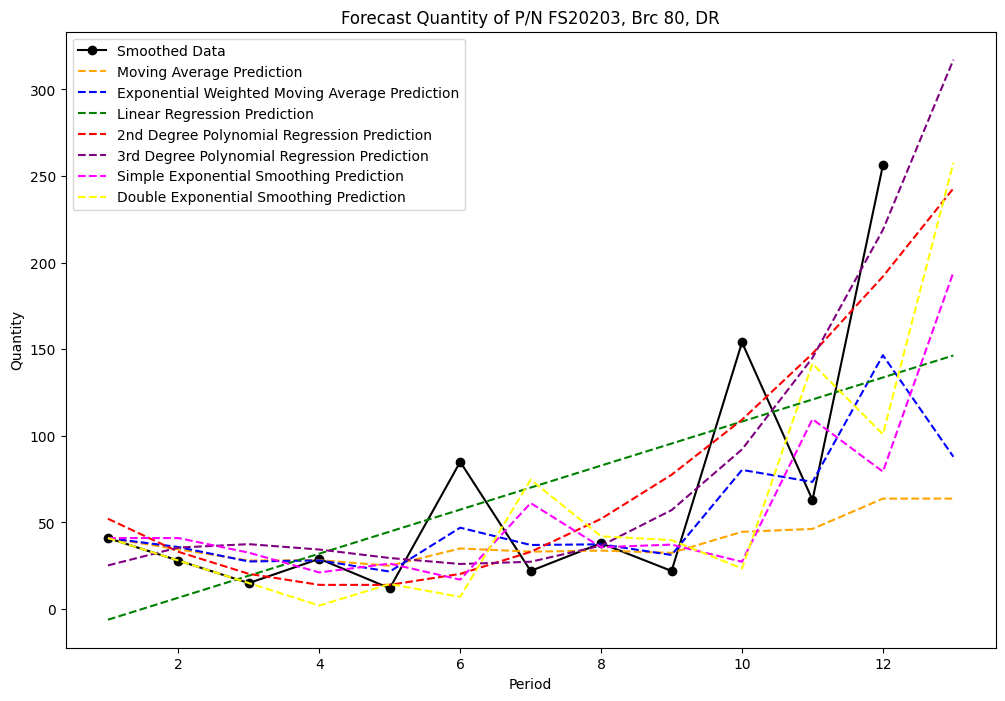

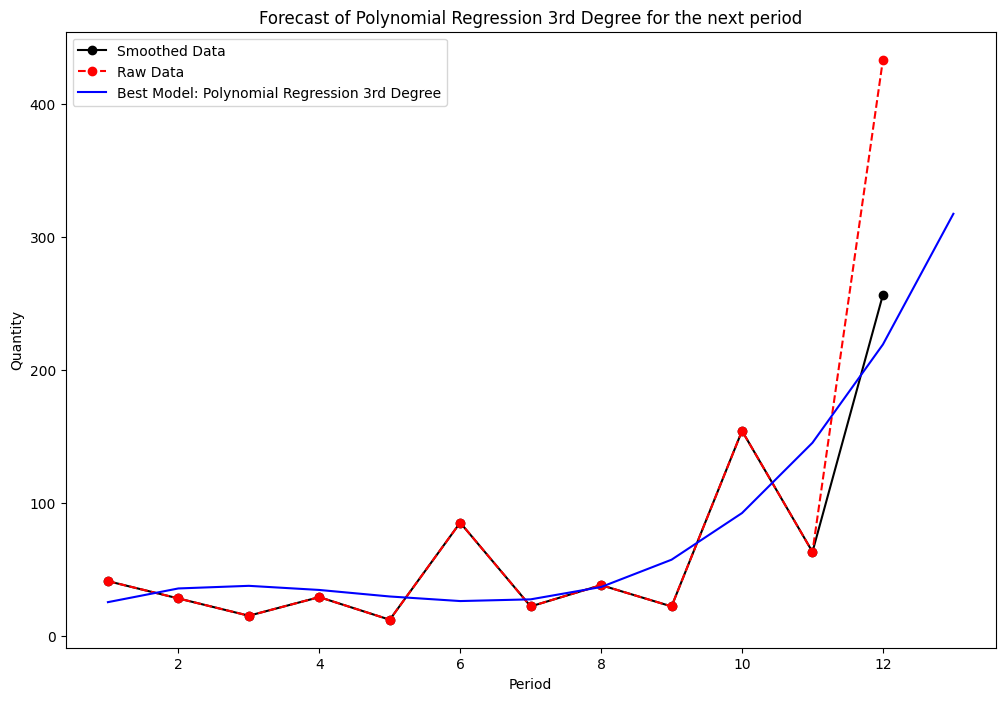

╒════╤═════════╤══════════╤════════════╤════════════════╤══════════════════╤═══════════════════════════╤═══════════════════════════════════════╤═════════════════════╤════════════════════════════════════╤════════════════════════════════════╤════════════════════════════════╤════════════════════════════════╕
│    │ P/N     │   Period │   Quantity │   Quantity_raw │   Moving Average │   Weighted Moving Average │   Exponential Weighted Moving Average │   Linear Regression │   Polynomial Regression 2nd Degree │   Polynomial Regression 3rd Degree │   Simple Exponential Smoothing │   Double Exponential Smoothing │
╞════╪═════════╪══════════╪════════════╪════════════════╪══════════════════╪═══════════════════════════╪═══════════════════════════════════════╪═════════════════════╪════════════════════════════════════╪════════════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│  0 │ FS20203 │        1 │     41     │             41 │          41      │   

In [8]:
#PROSES D-12 to D-1 to forecast D-0
def process_pn(data, pn_to_filter, brc_to_filter, dr_to_filter, agc_to_filter):
    data = clean_data_by_brc(data)
    filtered_data = data[
        (data['P/N'] == pn_to_filter) &
        (data['Brc'] == brc_to_filter) &
        (data['DR/\nNDR'] == dr_to_filter) &
        (data['Agc'] == agc_to_filter)
    ]
    formatted_data = []
    for index, row in filtered_data.iterrows():
        quantities = [row[f'D-{i}'] for i in range(1, 13)][::-1]
        for period, quantity in enumerate(quantities, start=1):
            formatted_data.append({
                'P/N': str(row['P/N']),
                'Period': period,
                'Quantity': quantity if not pd.isna(quantity) else None
            })
    formatted_df = pd.DataFrame(formatted_data)
    mean_quantity = formatted_df['Quantity'].mean()
    std_quantity = formatted_df['Quantity'].std()
    LB = 0
    UB = mean_quantity + 1.5 * std_quantity
    mean_quantity = round(mean_quantity, 4)
    std_quantity = round(std_quantity, 4)
    UB = round(UB, 4)
    table = [
        ["Mean Quantity", mean_quantity],
        ["Standard Deviation", std_quantity],
        ["Upper Bound (UB)", UB]
    ]
    print(tabulate(table, headers=["Metric", "Value"], tablefmt="pretty"))
    formatted_df['Quantity_raw'] = formatted_df['Quantity'].copy()
    formatted_df['Quantity'] = np.clip(formatted_df['Quantity'], LB, UB)
    formatted_df = pd.concat([
        formatted_df,
        pd.DataFrame({'Period': [13], 'Quantity': [np.nan]})
    ], ignore_index=True)
    return formatted_df
formatted_df = process_pn(data, pn_to_filter, brc_to_filter, dr_to_filter, agc_to_filter)

# MOVING AVERAGE
formatted_df['Period'] = np.arange(1, len(formatted_df) + 1)
formatted_df['Moving Average'] = np.nan
for i in range(1, len(formatted_df) + 1):
    formatted_df.loc[formatted_df['Period'] == i, 'Moving Average'] = formatted_df['Quantity'].iloc[:i].mean()
if len(formatted_df) == 12:
    last_12_mean = formatted_df['Quantity'].iloc[-12:].mean()
    formatted_df = pd.concat([
        formatted_df,
        pd.DataFrame({'Period': [13], 'Moving Average': [last_12_mean], 'Quantity': [np.nan]})
    ], ignore_index=True)

#WEIGHTED MOVING AVERAGE
def weighted_moving_average_custom(values, weights):
    n = len(weights)
    wma = [np.nan] * (n)
    for i in range(n, len(values)):
        wma_value = sum(w * v for w, v in zip(weights, values[i - n:i]))
        wma.append(wma_value)
    return wma
formatted_df['Weighted Moving Average'] = weighted_moving_average_custom(formatted_df['Quantity'].fillna(0), weights)
if 13 not in formatted_df['Period'].values:
    last_12_quantities = formatted_df['Quantity'].iloc[-12:].fillna(0)
    period_13_prediction = sum(w * q for w, q in zip(weights, last_12_quantities))
    formatted_df = pd.concat([
        formatted_df,
        pd.DataFrame({'Period': [13], 'Quantity': [np.nan], 'Weighted Moving Average': [period_13_prediction]})
    ], ignore_index=True)


# EXPONENTIAL WEIGHTED MOVING AVERAGE
def custom_exponential_weighted_moving_average(values, alpha):
    ewma_values = [values[0]]
    for t in range(1, len(values)):
        if pd.isna(values[t]):
            ewma_t = alpha * 0 + (1 - alpha) * ewma_values[-1]
        else:
            ewma_t = alpha * values[t] + (1 - alpha) * ewma_values[-1]
        ewma_values.append(ewma_t)
    return ewma_values
formatted_df['Exponential Weighted Moving Average'] = custom_exponential_weighted_moving_average(
    formatted_df['Quantity'].fillna(0), alpha_wma
)

# REGRESI LINEAR
valid_data = formatted_df.dropna(subset=['Quantity'])
X_linear = valid_data['Period']
y_linear = valid_data['Quantity']
n = len(X_linear)
x_mean = X_linear.mean()
y_mean = y_linear.mean()
slope = sum((X_linear - x_mean) * (y_linear - y_mean)) / sum((X_linear - x_mean) ** 2)
intercept = y_mean - slope * x_mean
formatted_df['Linear Regression'] = formatted_df['Period'].apply(lambda x: slope * x + intercept)

# POLINOM DERAJAT 2
X = valid_data[['Period']]
y = valid_data['Quantity']
degree_2 = 2
poly = PolynomialFeatures(degree=degree_2)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
X_all_poly = poly.transform(formatted_df[['Period']])
formatted_df['Polynomial Regression 2nd Degree'] = poly_model.predict(X_all_poly)

# POLINOM DERAJAT 3
degree_3 = 3
poly = PolynomialFeatures(degree=degree_3)
X_poly_3 = poly.fit_transform(X)
poly_model_3 = LinearRegression()
poly_model_3.fit(X_poly_3, y)
X_all_poly_3 = poly.transform(formatted_df[['Period']])
formatted_df['Polynomial Regression 3rd Degree'] = poly_model_3.predict(X_all_poly_3)

# SIMPLE EXPONENTIAL SMOOTHING
def apply_ses(values, alpha=alpha_ses):
    ses_model = SimpleExpSmoothing(values).fit(smoothing_level=alpha, optimized=False)
    return ses_model.fittedvalues

#DOUBLE EXPONENTIAL SMOOTHING
def apply_manual_des(values, alpha= alpha_ses, beta= beta_des):
    level = [values[0]]
    trend = [values[1] - values[0]]
    forecasts = [values[0]]
    for t in range(1, len(values)):
        forecast = level[t-1] + trend[t-1]
        forecasts.append(forecast)
        current_level = alpha * values[t] + (1 - alpha) * (level[t-1] + trend[t-1])
        current_trend = beta * (current_level - level[t-1]) + (1 - beta) * trend[t-1]
        level.append(current_level)
        trend.append(current_trend)
    return forecasts
formatted_df['Simple Exponential Smoothing'] = apply_ses(formatted_df['Quantity'], alpha=alpha_ses)
formatted_df['Double Exponential Smoothing'] = apply_manual_des(formatted_df['Quantity'], alpha=alpha_ses, beta=beta_des)

#MAE RMSE R2
results = []
for column in ['Moving Average', 'Exponential Weighted Moving Average', 'Linear Regression',
               'Polynomial Regression 2nd Degree', 'Polynomial Regression 3rd Degree',
               'Simple Exponential Smoothing', 'Double Exponential Smoothing']:
    # Exclude period 13 for calculating metrics
    valid_data = formatted_df.loc[formatted_df['Period'] != 13].dropna(subset=['Quantity', column])
    if valid_data.empty:
        print(f"Skipping {column} due to lack of valid data.")
        continue
    try:
        mae = round(mean_absolute_error(valid_data['Quantity'], valid_data[column]), 4)
        rmse = round(np.sqrt(mean_squared_error(valid_data['Quantity'], valid_data[column])), 4)
        r2 = round(r2_score(valid_data['Quantity'], valid_data[column]), 4)
        results.append({'Model': column, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    except Exception as e:
        print(f"Error evaluating {column}: {e}")

results_df = pd.DataFrame(results)

predictions_13th_period = []
for column in ['Moving Average', 'Exponential Weighted Moving Average', 'Linear Regression',
               'Polynomial Regression 2nd Degree', 'Polynomial Regression 3rd Degree',
               'Simple Exponential Smoothing', 'Double Exponential Smoothing', 'Weighted Moving Average']:
    if 13 in formatted_df['Period'].values:
        prediction_13 = formatted_df.loc[formatted_df['Period'] == 13, column].values[0]
    else:
        prediction_13 = None

    if column == 'Weighted Moving Average':
        # Use period 13 for calculating the absolute error
        valid_data = formatted_df.dropna(subset=['Quantity', column])
        mae = (
            round(mean_absolute_error(valid_data['Quantity'], valid_data[column]), 4)
            if not valid_data.empty
            else None
        )
        rmse = 'N/A'
        r2 = 'N/A'
    else:
        # Use metrics from results_df
        model_metrics = results_df[results_df['Model'] == column].iloc[0] if column in results_df['Model'].values else {'MAE': None, 'RMSE': None, 'R2': None}
        mae = model_metrics['MAE']
        rmse = model_metrics['RMSE']
        r2 = model_metrics['R2']

    predictions_13th_period.append({
        'Model': column,
        'Forecast Demand': round(max(0, prediction_13), 4) if prediction_13 is not None else None,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

comparison_df = pd.DataFrame(predictions_13th_period)
comparison_df['R2'] = comparison_df['R2'].replace('N/A', np.nan).astype(float)
# Sort results_df by R2 in descending order
sorted_results_df = results_df.sort_values(by='R2', ascending=False)

#BEST MODEL
best_model_row = results_df.loc[results_df['R2'].idxmax()]
best_model_name = best_model_row['Model']
best_model_r2 = best_model_row['R2']
best_model_mae = best_model_row['MAE']
best_model_rmse = best_model_row['RMSE']
next_period_prediction = max(0, formatted_df.loc[formatted_df['Period'] == 13, best_model_name].values[0])

#PLOT SEMUA GRAFIK
plt.figure(figsize=(12, 8))
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Smoothed Data', marker='o', color='black')
plt.plot(formatted_df['Period'], formatted_df['Moving Average'], label='Moving Average Prediction', linestyle='--', color='orange')
plt.plot(formatted_df['Period'], formatted_df['Exponential Weighted Moving Average'], label='Exponential Weighted Moving Average Prediction', linestyle='--', color='blue')
plt.plot(formatted_df['Period'], formatted_df['Linear Regression'], label='Linear Regression Prediction', linestyle='--', color='green')
plt.plot(formatted_df['Period'], formatted_df['Polynomial Regression 2nd Degree'], label='2nd Degree Polynomial Regression Prediction', linestyle='--', color='red')
plt.plot(formatted_df['Period'], formatted_df['Polynomial Regression 3rd Degree'], label='3rd Degree Polynomial Regression Prediction', linestyle='--', color='purple' )
plt.plot(formatted_df['Period'], formatted_df['Simple Exponential Smoothing'], label='Simple Exponential Smoothing Prediction', linestyle='--', color='magenta' )
plt.plot(formatted_df['Period'], formatted_df['Double Exponential Smoothing'], label='Double Exponential Smoothing Prediction', linestyle='--', color='yellow' )
plt.xlabel('Period')
plt.ylabel('Quantity')
plt.title(f'Forecast Quantity of P/N {pn_to_filter}, Brc {brc_to_filter}, {dr_to_filter}')
plt.legend()
plt.grid(False)
plt.show()

# PLOT BEST MODEL
plt.figure(figsize=(12,8))
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Smoothed Data', marker='o', color='black')
plt.plot(formatted_df['Period'], formatted_df['Quantity_raw'], label='Raw Data', linestyle='--', marker='o', color='red')
plt.plot(formatted_df['Period'], formatted_df[best_model_name], label=f'Best Model: {best_model_name}', linestyle='-', color='blue')
plt.xlabel('Period')
plt.ylabel('Quantity')
plt.title(f'Forecast of {best_model_name} for the next period')
plt.legend()
plt.grid(False)
plt.show()

print(tabulate(formatted_df, headers='keys', tablefmt='fancy_grid'))
table_data = [
    ["P/N", pn_to_filter],
    ["Best Model", best_model_name],
    ["Best R-squared", f"{best_model_r2:.4f}"],
    ["Best MAE", f"{best_model_mae:.4f}"],
    ["Best RMSE", f"{best_model_rmse:.4f}"],
    ["Forecast Demand D-0", f"{next_period_prediction:.4f}"]
]
# Combine comparison_df and results_df, ensuring alignment
comparison_df_sorted = comparison_df.sort_values(by='R2', ascending=False)
# Tabulate the sorted DataFrame
print(tabulate(comparison_df_sorted, headers='keys', tablefmt='fancy_grid'))
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

#EXPORT
output_file_path = 'results.json'
formatted_df.to_json(output_file_path, orient='records', indent=4)

print(f"Data saved to {output_file_path}")